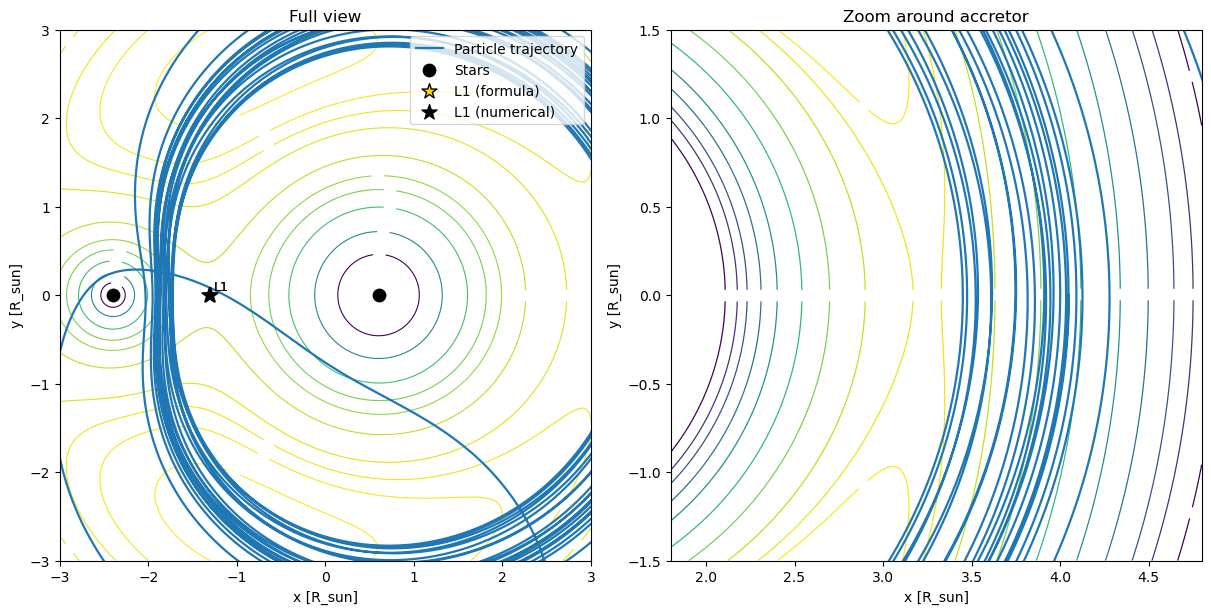

In [16]:

# Path of a Particle in Roche Potential

# ----- Libraries -----
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# ----- Constants ------
G = 6.67430e-11          # [m^3 kg^-1 s^-2] gravitational constant
M_sun = 1.98847e30       # [kg] solar mass
R_sun = 6.957e8          # [m] solar radius

# ----- Model Parameters -----
M_c = 1.4 * M_sun        # [kg] accretor (e.g., neutron star)
M_s = 0.35 * M_sun       # [kg] donor star
a   = 3 * R_sun       # [m] separation between object centers

# ----- Positions of Stars in (Barycentric) Coordinate System -----

x_c =  a * M_s / (M_c + M_s)    # [m] accretor on right
y_c = 0.0                       # [m]
x_s = -a * M_c / (M_c + M_s)    # [m] donor on left
y_s = 0.0                       # [m]

r_c = np.array([x_c, y_c], dtype=float) # accretor position
r_s = np.array([x_s, y_s], dtype=float) # donor position  

# ----- Binary orbital angular speed -----
Omega = np.sqrt(G * (M_c + M_s) / a**3)    # [rad/s]
Period = 2.0 * np.pi / Omega               # [s] orbital period

# ------ Dynamics Functions ------

def accel_xy(x, y, vx, vy):

    """
    Provided the position (x,y) and velocity (vx,vy) of a test particle in the
    rotating frame, this function return the acceleration (ax,ay) in that frame.
    a = gravity(M_c) + gravity(M_s) + centrifugal + coriolis
    """
    
    # Dispacement components from stars to particle
    dx_c = x - r_c[0]
    dy_c = y - r_c[1]
    dx_s = x - r_s[0]
    dy_s = y - r_s[1]

    # Distances squared
    rc2 = dx_c*dx_c + dy_c*dy_c
    rs2 = dx_s*dx_s + dy_s*dy_s

    # Distances |r|^3
    rc32 = rc2 * np.sqrt(rc2)
    rs32 = rs2 * np.sqrt(rs2)

    # Gravity (per unit mass)
    ax_g = -G * M_c * dx_c / rc32 - G * M_s * dx_s / rs32
    ay_g = -G * M_c * dy_c / rc32 - G * M_s * dy_s / rs32

    # Centrifugal (about CM at origin)
    ax_cent = Omega * Omega * x
    ay_cent = Omega * Omega * y

    # Coriolis
    ax_cor =  2.0 * Omega * vy
    ay_cor = -2.0 * Omega * vx

    # Acceleration components
    ax = ax_g + ax_cent + ax_cor
    ay = ay_g + ay_cent + ay_cor
    
    return ax, ay

def time_derivative(state):
    """
    Returns the time derivatives [dx/dt, dy/dt, dvx/dt, dvy/dt]
    for a particle in the rotating frame, given its current state.
    
    state = [x, y, vx, vy]
    """
    # Unpack state vector
    x, y, vx, vy = state
    
    # Compute accelerations from forces
    ax, ay = accel_xy(x, y, vx, vy)
    
    # Return the derivative of the state
    return np.array([vx, vy, ax, ay], dtype=float)

def rk4_step(state, dt):
    """
    Perform a single 4th-order Runge–Kutta integration step.
    
    state = [x, y, vx, vy]
    dt    = timestep
    """
    # Evaluate intermediate slopes
    k1 = time_derivative(state)
    k2 = time_derivative(state + 0.5 * dt * k1)
    k3 = time_derivative(state + 0.5 * dt * k2)
    k4 = time_derivative(state + dt * k3)
    
    # Return the updated state (fourth-order accurate)
    new_state = state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return new_state

# ----- Fizix Functions -----

def roche_potential(x, y, eps=1e7):
    
    # Dispacement components from stars to particle
    dx_c = x - r_c[0]
    dy_c = y - r_c[1]
    dx_s = x - r_s[0]
    dy_s = y - r_s[1]

    # Distances with softening to avoid singularities
    rc = np.sqrt(dx_c*dx_c + dy_c*dy_c + eps*eps)
    rs = np.sqrt(dx_s*dx_s + dy_s*dy_s + eps*eps)

    # Roche potential
    roche_potential = -G*M_c/rc - G*M_s/rs - 0.5 * (Omega**2) * (x*x + y*y)
    
    return roche_potential

def l1_from_formula(x_c, x_s, a, M_c, M_s, use_log10=True):
    q = M_c / M_s                          # (donor / compact)
    logq = np.log10(q) if use_log10 else np.log(q)
    b1 = a * (0.500 + 0.227 * logq)        # distance from compact star to L1
    # put L1 along the line from compact star toward the donor
    dir_sign = np.sign(x_s - x_c)          # +1 if donor to the right, -1 if to the left
    x_L1 = x_c + dir_sign * b1
    y_L1 = 0.0                             # your stars lie on y=0
    return x_L1, y_L1

def dPhi_dx(x, eps=1e7):
    """Derivative of Roche potential along x-axis (y=0)."""
    dx_c = x - r_c[0]
    dx_s = x - r_s[0]
    rc3 = (dx_c**2 + eps**2)**1.5
    rs3 = (dx_s**2 + eps**2)**1.5
    # derivative of effective potential wrt x
    return G*M_c*dx_c/rc3 + G*M_s*dx_s/rs3 - Omega**2 * x

# ----- Initial Conditions -----

x0 = x_c + 1.15 * a     # [m]                                           *******************************************************************
y0 = 0.0                # [m]
vx0 = 0.0               # [m/s]
vy0 = -6.211e5              # [m/s]                                         *******************************************************************

state0 = np.array([x0, y0, vx0, vy0], dtype=float)

# ----- Integration Controls -----

dt = 2            # [s] #                                    *******************************************************************
Nsteps = 10000000     # total steps #                                    *******************************************************************

# ----- Integrator -----

traj = np.empty((Nsteps, 4), dtype=float) # to store trajectory
state = state0.copy()

for i in range(Nsteps):
    
    traj[i] = state

    # Stop if particle gets too close to accretor
    dx, dy = state[0] - x_c, state[1] - y_c
    if np.hypot(dx, dy) < 0.1 * a: # [m] Radius threshold
        traj = traj[:i+1]
        break

    state = rk4_step(state, dt)

x_traj, y_traj, vx_traj, vy_traj = traj.T

# ----- Plotting -----

# Grid
size = 2 * a
nx = ny = 400
xs = np.linspace(-size*0.5, size*0.5, nx)
ys = np.linspace(-size*0.5, size*0.5, ny)
XX, YY = np.meshgrid(xs, ys)

# Plotting equipotentials
Phi_grid = roche_potential(XX, YY)
levels_full = np.quantile(Phi_grid, [0.02, 0.05, 0.10, 0.15, 0.20, 0.30, 0.45, 0.60, 0.75, 0.90])

# Grid for zoomed view
zoom = 0.5 * a  #                                    *******************************************************************
displacement = 0.9 * a #                                    *******************************************************************
nxz = nyz = 500
xsz = np.linspace(x_c + displacement - zoom, x_c + displacement + zoom, nxz)
ysz = np.linspace(y_c - zoom, y_c + zoom, nyz)
XXz, YYz = np.meshgrid(xsz, ysz)

# Plotting equipotentials in zoomed view
Phi_grid_z = roche_potential(XXz, YYz)
levels_zoom = np.quantile(Phi_grid_z, [0.05, 0.10, 0.15, 0.22, 0.30, 0.42, 0.55, 0.70, 0.85, 0.95])

# Make Figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Mark L1 point (from formula) AND then from numerical root finding
x_L1f, y_L1f = l1_from_formula(x_c, x_s, a, M_c, M_s, use_log10=True)
x_L1n, y_L1n = brentq(dPhi_dx, r_c[0], r_s[0]), 0

# Left: full view
cs1 = ax1.contour(XX/R_sun, YY/R_sun, Phi_grid, levels=levels_full, linewidths=0.8)
ax1.clabel(cs1, inline=True, fontsize=7, fmt="")
ax1.plot(x_traj/R_sun, y_traj/R_sun, lw=1.6, label='Particle trajectory')
ax1.scatter([x_c/R_sun, x_s/R_sun], [y_c/R_sun, y_s/R_sun], s=80, c='k', marker='o', label='Stars')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x [R_sun]')
ax1.set_ylabel('y [R_sun]')
ax1.set_title('Full view')
ax1.legend(loc='upper right', frameon=True)
ax1.set_xlim(-size*0.5/R_sun, size*0.5/R_sun)
ax1.set_ylim(-size*0.5/R_sun, size*0.5/R_sun)

ax1.scatter(x_L1f/R_sun, y_L1f/R_sun, s=130, c='gold', marker='*', edgecolor='k', zorder=5, label='L1 (formula)')
ax1.text(x_L1f/R_sun + 0.05, y_L1f/R_sun + 0.05, 'L1', color='k', fontsize=9)
ax1.legend(loc='upper right', frameon=True)

ax1.scatter(x_L1n/R_sun, y_L1n/R_sun, s=130, c='black', marker='*', edgecolor='k', zorder=5, label='L1 (numerical)')
ax1.text(x_L1n/R_sun + 0.05, y_L1n/R_sun + 0.05, 'L1', color='k', fontsize=9)
ax1.legend(loc='upper right', frameon=True)

# Right: zoom on accretor
cs2 = ax2.contour(XXz/R_sun, YYz/R_sun, Phi_grid_z, levels=levels_zoom, linewidths=0.9)
ax2.clabel(cs2, inline=True, fontsize=7, fmt="")
ax2.plot(x_traj/R_sun, y_traj/R_sun, lw=1.6)
ax2.scatter([x_c/R_sun], [y_c/R_sun], s=90, c='k', marker='o')
ax2.set_aspect('equal', 'box')
ax2.set_xlabel('x [R_sun]')
ax2.set_ylabel('y [R_sun]')
ax2.set_title('Zoom around accretor')
x_center = x_c + displacement
ax2.set_xlim((x_center - zoom)/R_sun, (x_center + zoom)/R_sun)
ax2.set_ylim((y_c - zoom)/R_sun, (y_c + zoom)/R_sun)

plt.show()


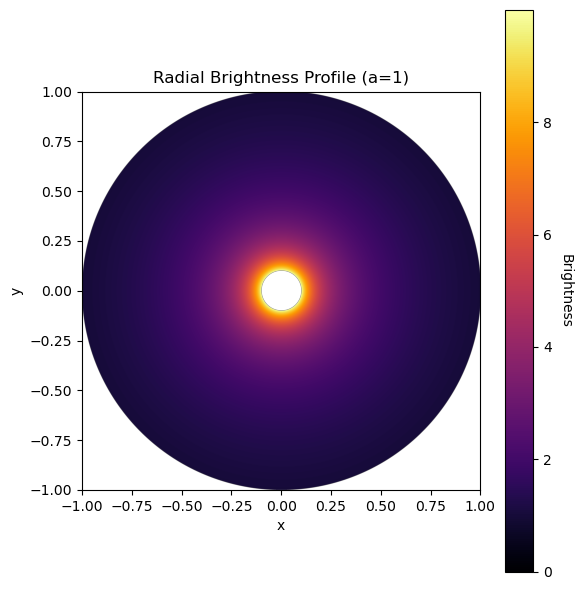

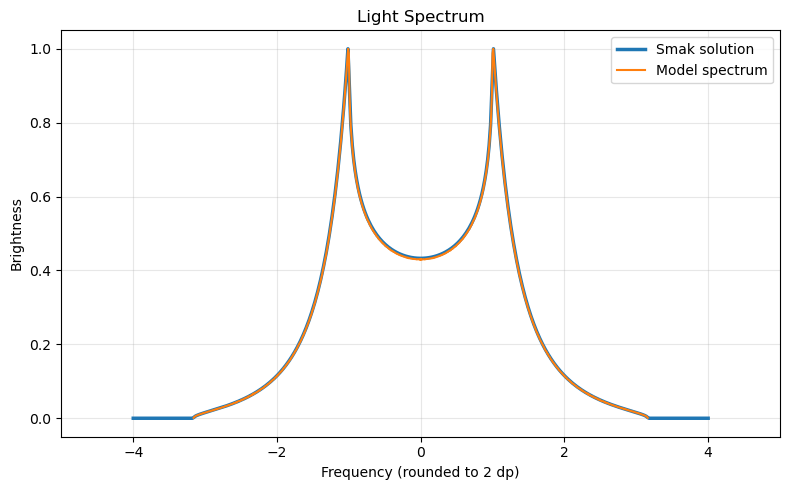

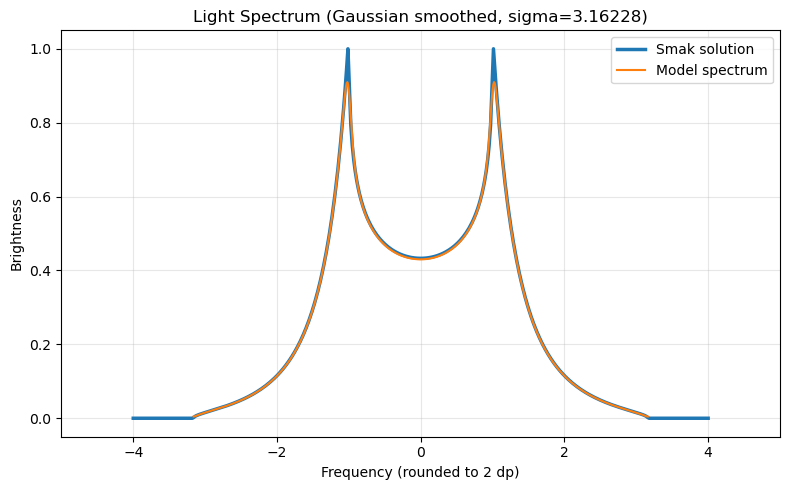

In [ ]:
# Accretion Disc Spectrum Model

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ----- INITIALISE -----
Rmax = 1
Rmin = 0.1
N = 5000
eps = 1e-12

coords = np.linspace(-Rmax, Rmax, N)     # 1D coordinate vector
X, Y = np.meshgrid(coords, coords)       # 2D grid
R = np.hypot(X, Y)                       # distances from origin
theta = np.arctan2(Y, X)                 # angles from origin
mask = (R >= Rmin) & (R <= Rmax)         # points within the disc
extent = [-Rmax, Rmax, -Rmax, Rmax]      # CHAT - imshow extent for plotting
# a = [0, 0.5, 1, 1.5, 2, 2.5]
a = 1

# ----- PROFILE FUNCTION -----
def profile2d(func, R, theta, mask,
              eps=1e-15,
              plot=False,
              colourmap="viridis",
              vmin=None, vmax=None,
              title="Profile",
              x_label="x", y_label="y",
              colour_bar_name="Value",
              extent=None,
              ax=None,
              symmetric=False,   # set symmetric color limits around 0 (for signed fields)
              nonneg=False       # force vmin=0 and vmax=max (for non-negative fields)
              ):
    """
    Compute a 2D profile from func(r, theta) on the masked domain, optionally plot it.
    """
    # Compute values
    values = np.full_like(R, np.nan, dtype=float)
    values[mask] = func(np.maximum(R[mask], eps), theta[mask])

    # Handle extent - CHAT
    if extent is None:
        # Fallback: infer square extent from max radius in mask
        rmax = np.nanmax(R[mask])
        extent = [-rmax, rmax, -rmax, rmax]

    # Auto color scaling helpers - CHAT
    if symmetric:
        vmax_auto = np.nanmax(np.abs(values))
        vmin_plot = -vmax_auto if vmin is None else vmin
        vmax_plot =  vmax_auto if vmax is None else vmax
    elif nonneg:
        vmin_plot = 0.0 if vmin is None else vmin
        vmax_plot = np.nanmax(values) if vmax is None else vmax
    else:
        vmin_plot = vmin
        vmax_plot = vmax

    # Optional plotting
    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
        else:
            fig = ax.figure

        img = ax.imshow(
            values,
            extent=extent,
            origin="lower",
            cmap=colourmap,
            aspect="equal",
            vmin=vmin_plot, vmax=vmax_plot
        )
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label(colour_bar_name, rotation=270, labelpad=15)

        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        plt.tight_layout()
        plt.show()

    return values

# ----- CREATE PROFILES -----

# Velocity-like profile: cos(t)/sqrt(r), signed -> use symmetric=True
velocity = profile2d(
    lambda r, t: np.cos(t) / np.sqrt(r),
    R, theta, mask,
    eps=eps,
    plot=0,
    colourmap="seismic",
    title="Doppler Shift",
    colour_bar_name="Velocity",
    extent=extent,
    symmetric=True
)

# Radial Brightness profile: r^(-a), non-negative -> use nonneg=True

brightnessrad = profile2d(
    lambda r, th: r**(-a),
    R, theta, mask,
    eps=eps,
    plot=1,
    colourmap="inferno",
    title=f"Radial Brightness Profile (a={a})",
    colour_bar_name="Brightness",
    extent=extent,
    nonneg=True
)

# ----- DATA ANALYSIS -----

# Parameters
p = 2  # decimal places
# Extract net freq and brightness
frequency = np.round(velocity, p) # discretise by rounding
brightness = brightnessrad

# Keep valid points
valid = np.isfinite(frequency) & np.isfinite(brightness)
f = frequency[valid]
w = brightness[valid]

# Group by unique rounded frequency and sum brightness
unique_f, inverse = np.unique(f, return_inverse=True)
sum_brightness = np.bincount(inverse, weights=w)
# Result: unique_f (frequencies), sum_brightness (total brightness per frequency)

# Normalise max brightness to to 1
sum_brightness_norm = sum_brightness / np.max(sum_brightness)

# ----- SMAK ANALYTICAL SOLUTION -----

import numpy as np

def I(a, x):
    eps = 1e-12
    y = np.nan
    if abs(x) <= 1.0:
        s = np.sqrt(1.0 - x**2)
        if a == 0.0:
            y = -((x**3)/4.0 + (3.0*x)/8.0) * s + (3.0/8.0) * np.arcsin(x)
        elif a == 0.5:
            y = (1.0/3.0) * (s**3) - s
        elif a == 1.0:
            y = -(x/2.0) * s + 0.5 * np.arcsin(x)
        elif a == 1.5:
            y = -s
        elif a == 2.0:
            y = np.arcsin(x)
        elif a == 2.5:
            y = np.log(abs((1.0 - s) / x)) if abs(x) > eps else np.nan
        else:
            raise NotImplementedError("Only a ∈ {0,0.5,1,1.5,2,2.5} supported.")
    return y

def I_difference(a, u, Rmin):
    x_z = np.clip(u, -1.0, 1.0)
    x_1 = np.clip(u*np.sqrt(Rmin), -1.0, 1.0)
    return I(a, x_z) - I(a, x_1)

Smak_u = np.linspace(-4.0, 4.0, 400)          # x_plotting
Smak_F = np.full_like(Smak_u, np.nan, float)   # y_plotting

exp = 2*a - 5
rootR = np.sqrt(Rmin)

for i, u in enumerate(Smak_u):
    # guard the singular prefactor at u=0 if exponent < 0
    if abs(u) < 1e-12 and exp < 0:
        Smak_F[i] = np.nan
        continue

    x_z = np.clip(u, -1.0, 1.0)
    x_1 = np.clip(u*rootR, -1.0, 1.0)

    upper = I(a, x_z)
    lower = I(a, x_1)
    diff  = upper - lower

    Smak_F[i] = (u**exp) * diff

# normalise robustly (optional)
finite = np.isfinite(Smak_F)
if finite.any():
    amp = np.nanmax(np.abs(Smak_F))
    Smak_F_norm = Smak_F / amp if (np.isfinite(amp) and amp > 0) else Smak_F
else:
    Smak_F_norm = Smak_F

# ----- PLOT SPECTRUM -----

def plot_spectrum(unique_f,
                  sum_brightness_norm,
                  Smak_u=None,
                  Smak_F_norm=None,
                  *,
                  p=2,
                  xlim=(-5, 5),
                  Smak=False,
                  sigma=None,
                  xlabel="Frequency",
                  ylabel="Brightness",
                  title="Light Spectrum",
                  figsize=(8, 5),
                  grid_alpha=0.3):

    # Make safe copies
    x = np.asarray(unique_f)
    y = np.asarray(sum_brightness_norm)

    # Optional gaussian smoothing
    if sigma is not None and sigma > 0:
        if gaussian_filter1d is None:
            raise RuntimeError("gaussian_filter1d not available; install SciPy or remove smoothing.")
        y = gaussian_filter1d(y, sigma=sigma)
        title = f"{title} (Gaussian smoothed, sigma={sigma:g})"

    # Plot
    plt.figure(figsize=figsize)

    if Smak:
        if Smak_u is None or Smak_F_norm is None:
            raise ValueError("Smak=True but Smak_u/Smak_F_norm not provided.")
        plt.plot(Smak_u, Smak_F_norm, linestyle='-', linewidth=2.5, label='Smak solution')
        plt.plot(x, y, linestyle='-', label='Model spectrum')
        plt.legend()
    else:
        plt.plot(x, y, linestyle='-')

    plt.xlabel(f"{xlabel} (rounded to {p} dp)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=grid_alpha)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.tight_layout()
    plt.show()

# Raw spectrum (no smoothing)
plot_spectrum(
    unique_f, sum_brightness_norm,
    Smak_u=Smak_u, Smak_F_norm=Smak_F_norm,
    p=p, sigma=None, Smak=True, title="Light Spectrum"
)

# Smoothed spectrum
plot_spectrum(
    unique_f, sum_brightness_norm,
    Smak_u=Smak_u, Smak_F_norm=Smak_F_norm,
    p=p, sigma=(10**(1/p)), Smak=True, title="Light Spectrum"
)


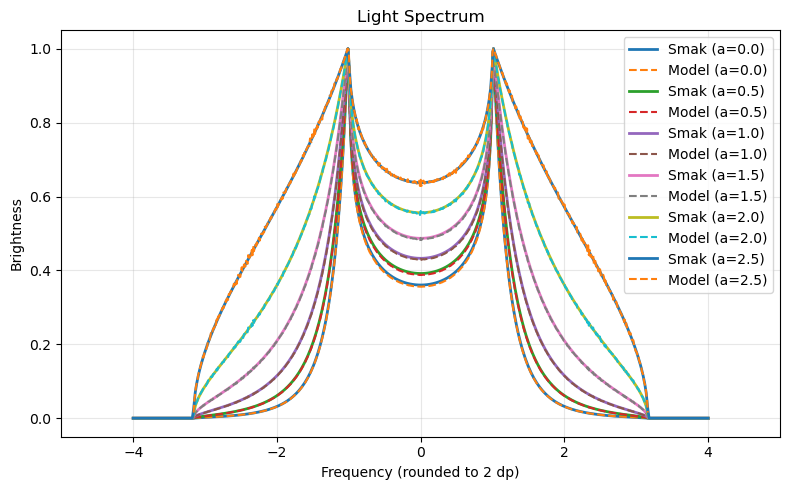

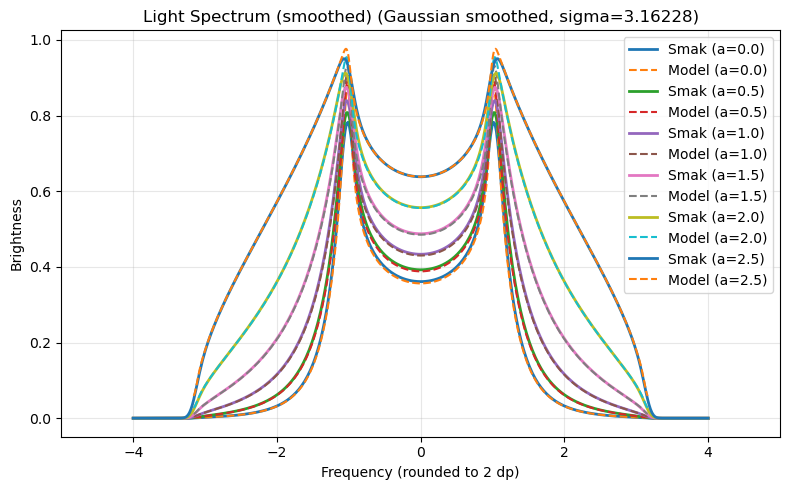

In [3]:
#Code to be destroyed

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ----- INITIALISE -----
Rmax = 1
Rmin = 0.1
N = 5000
eps = 1e-12

coords = np.linspace(-Rmax, Rmax, N)     # 1D coordinate vector
X, Y = np.meshgrid(coords, coords)       # 2D grid
R = np.hypot(X, Y)                       # distances from origin
theta = np.arctan2(Y, X)                 # angles from origin
mask = (R >= Rmin) & (R <= Rmax)         # points within the disc
extent = [-Rmax, Rmax, -Rmax, Rmax]      # CHAT - imshow extent for plotting
a = [0, 0.5, 1, 1.5, 2, 2.5]

# ----- PROFILE FUNCTION -----
def profile2d(func, R, theta, mask,
              eps=1e-15,
              plot=False,
              colourmap="viridis",
              vmin=None, vmax=None,
              title="Profile",
              x_label="x", y_label="y",
              colour_bar_name="Value",
              extent=None,
              ax=None,
              symmetric=False,   # set symmetric color limits around 0 (for signed fields)
              nonneg=False       # force vmin=0 and vmax=max (for non-negative fields)
              ):
    """
    Compute a 2D profile from func(r, theta) on the masked domain, optionally plot it.
    """
    # Compute values
    values = np.full_like(R, np.nan, dtype=float)
    values[mask] = func(np.maximum(R[mask], eps), theta[mask])

    # Handle extent - CHAT
    if extent is None:
        # Fallback: infer square extent from max radius in mask
        rmax = np.nanmax(R[mask])
        extent = [-rmax, rmax, -rmax, rmax]

    # Auto color scaling helpers - CHAT
    if symmetric:
        vmax_auto = np.nanmax(np.abs(values))
        vmin_plot = -vmax_auto if vmin is None else vmin
        vmax_plot =  vmax_auto if vmax is None else vmax
    elif nonneg:
        vmin_plot = 0.0 if vmin is None else vmin
        vmax_plot = np.nanmax(values) if vmax is None else vmax
    else:
        vmin_plot = vmin
        vmax_plot = vmax

    # Optional plotting
    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
        else:
            fig = ax.figure

        img = ax.imshow(
            values,
            extent=extent,
            origin="lower",
            cmap=colourmap,
            aspect="equal",
            vmin=vmin_plot, vmax=vmax_plot
        )
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label(colour_bar_name, rotation=270, labelpad=15)

        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        plt.tight_layout()
        plt.show()

    return values

# ----- CREATE PROFILES -----

values_1 = []
values_2 = []

for i in a:

    # Velocity-like profile: cos(t)/sqrt(r), signed -> use symmetric=True
    velocity = profile2d(
        lambda r, t: np.cos(t) / np.sqrt(r),
        R, theta, mask,
        eps=eps,
        plot=0,
        colourmap="seismic",
        title="Doppler Shift",
        colour_bar_name="Velocity",
        extent=extent,
        symmetric=True
    )

    # Radial Brightness profile: r^(-a), non-negative -> use nonneg=True

    brightnessrad = profile2d(
        lambda r, th: r**(-i),
        R, theta, mask,
        eps=eps,
        plot=0,
        colourmap="inferno",
        title=f"Radial Brightness Profile (a={i})",
        colour_bar_name="Brightness",
        extent=extent,
        nonneg=True
    )

    # ----- DATA ANALYSIS -----

    # Parameters
    p = 2  # decimal places
    # Extract net freq and brightness
    frequency = np.round(velocity, p) # discretise by rounding
    brightness = brightnessrad

    # Keep valid points
    valid = np.isfinite(frequency) & np.isfinite(brightness)
    f = frequency[valid]
    w = brightness[valid]

    # Group by unique rounded frequency and sum brightness
    unique_f, inverse = np.unique(f, return_inverse=True)
    sum_brightness = np.bincount(inverse, weights=w)
    # Result: unique_f (frequencies), sum_brightness (total brightness per frequency)

    # Normalise max brightness to to 1
    sum_brightness_norm = sum_brightness / np.max(sum_brightness)

    values_1.append(sum_brightness_norm)

# ----- SMAK ANALYTICAL SOLUTION -----


def I(a, x):
    eps = 1e-12
    y = np.nan
    if abs(x) <= 1.0:
        s = np.sqrt(1.0 - x**2)
        if a == 0.0:
            y = -((x**3)/4.0 + (3.0*x)/8.0) * s + (3.0/8.0) * np.arcsin(x)
        elif a == 0.5:
            y = (1.0/3.0) * (s**3) - s
        elif a == 1.0:
            y = -(x/2.0) * s + 0.5 * np.arcsin(x)
        elif a == 1.5:
            y = -s
        elif a == 2.0:
            y = np.arcsin(x)
        elif a == 2.5:
            y = np.log(abs((1.0 - s) / x)) if abs(x) > eps else np.nan
        else:
            raise NotImplementedError("Only a ∈ {0,0.5,1,1.5,2,2.5} supported.")
    return y

def I_difference(a, u, Rmin):
    x_z = np.clip(u, -1.0, 1.0)
    x_1 = np.clip(u*np.sqrt(Rmin), -1.0, 1.0)
    return I(a, x_z) - I(a, x_1)

Smak_u = np.linspace(-4.0, 4.0, 400)          # x_plotting

for i in a:

    Smak_F = np.full_like(Smak_u, np.nan, float)   # y_plotting

    exp = 2*i - 5
    rootR = np.sqrt(Rmin)

    for j, u in enumerate(Smak_u):
        # guard the singular prefactor at u=0 if exponent < 0
        if abs(u) < 1e-12 and exp < 0:
            Smak_F[j] = np.nan
            continue

        x_z = np.clip(u, -1.0, 1.0)
        x_1 = np.clip(u*rootR, -1.0, 1.0)

        upper = I(i, x_z)
        lower = I(i, x_1)
        diff  = upper - lower

        Smak_F[j] = (u**exp) * diff

    # normalise robustly (optional)
    finite = np.isfinite(Smak_F)
    if finite.any():
        amp = np.nanmax(np.abs(Smak_F))
        Smak_F_norm = Smak_F / amp if (np.isfinite(amp) and amp > 0) else Smak_F
    else:
        Smak_F_norm = Smak_F

    values_2.append(Smak_F_norm)

# ----- PLOT SPECTRUM -----

def plot_spectrum(unique_f,
                  values_1,             # list/tuple of 1D arrays (model y for each a)
                  Smak_u=None,
                  values_2=None,        # list/tuple of 1D arrays (Smak y for each a)
                  *,
                  a_vals=None,          # e.g. [0,0.5,1,1.5,2,2.5]
                  p=2,
                  xlim=(-5, 5),
                  Smak=False,
                  sigma=None,
                  xlabel="Frequency",
                  ylabel="Brightness",
                  title="Light Spectrum",
                  figsize=(8, 5),
                  grid_alpha=0.3):

    x = np.asarray(unique_f)

    n = len(values_1)
    if Smak:
        if Smak_u is None or values_2 is None:
            raise ValueError("Smak=True but Smak_u/values_2 not provided.")
        if len(values_2) != n:
            raise ValueError("values_1 and values_2 must have same length (same # of a values).")

    if a_vals is None:
        a_vals = list(range(n))

    plt.figure(figsize=figsize)

    for i in range(n):
        y1 = np.asarray(values_1[i])
        if sigma is not None and sigma > 0:
            if gaussian_filter1d is None:
                raise RuntimeError("gaussian_filter1d not available; install SciPy or set sigma=None.")
            y1 = gaussian_filter1d(y1, sigma=sigma)

        if Smak:
            y2 = np.asarray(values_2[i])
            if sigma is not None and sigma > 0:
                y2 = gaussian_filter1d(y2, sigma=sigma)

            # label first pair to avoid legend spam
            lbl_smak  = f"Smak (a={a_vals[i]})"
            lbl_model = f"Model (a={a_vals[i]})"
            plt.plot(Smak_u, y2, linestyle='-', linewidth=2.0, label=lbl_smak)
            plt.plot(x,      y1, linestyle='--',              label=lbl_model)
        else:
            plt.plot(x, y1, linestyle='-', label=f"a={a_vals[i]}")

    plt.xlabel(f"{xlabel} (rounded to {p} dp)")
    plt.ylabel(ylabel)
    smoothtag = f" (Gaussian smoothed, sigma={sigma:g})" if (sigma is not None and sigma > 0) else ""
    plt.title(title + smoothtag)
    plt.grid(True, alpha=grid_alpha)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- usage ----
a_vals = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]

# Raw (no smoothing)
plot_spectrum(
    unique_f, values_1,
    Smak_u=Smak_u, values_2=values_2,
    a_vals=a_vals, p=p, sigma=None, Smak=True,
    title="Light Spectrum"
)

# Smoothed
plot_spectrum(
    unique_f, values_1,
    Smak_u=Smak_u, values_2=values_2,
    a_vals=a_vals, p=p, sigma=(10**(1/p)), Smak=True,
    title="Light Spectrum (smoothed)"
)



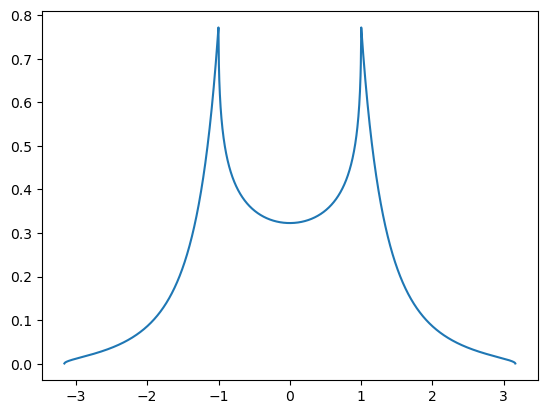

In [39]:
# ----- SMAK ANALYTICAL SOLUTION -----

import numpy as np

def I(a, x):
    """
    Analytical solution I(a, x).
    Returns np.nan if undefined (|x| > 1, or x=0 with a=2.5).
    """
    eps = 1e-12

    # default to NaN
    y = np.nan

    if abs(x) <= 1.0:          # inside disc
        s = np.sqrt(1.0 - x**2)

        if a == 0.0:
            y = -((x**3)/4.0 + (3.0*x)/8.0) * s + (3.0/8.0) * np.arcsin(x)
        elif a == 0.5:
            y = (1.0/3.0) * (s**3) - s
        elif a == 1.0:
            y = -(x/2.0) * s + 0.5 * np.arcsin(x)
        elif a == 1.5:
            y = -s
        elif a == 2.0:
            y = np.arcsin(x)
        elif a == 2.5:
            if abs(x) > eps:   # avoid division by zero
                y = np.log(abs((1.0 - s) / x))
            else:
                y = np.nan     # undefined at x=0
        else:
            raise NotImplementedError("Only a ∈ {0,0.5,1,1.5,2,2.5} supported.")

    return y

def I_difference(a, x):
    upper = I(a, x_z)
    lower = I(a, x)
    difference = upper - lower
    return difference

Smak_u = np.linspace(-4.0, 4.0, 4000) #x_plotting
Smak_F = np.full_like(Smak_u, np.nan) #y_plotting

for i in range(0, len(Smak_u) - 1, 1):

    x_1 = Smak_u[i] * Rmin**0.5
    x_z = np.clip(Smak_u[i], -1.0, 1.0)

    upper = I(a, x_z)
    lower = I(a, x_1)
    
    difference = upper - lower

    Smak_F[i] = Smak_u[i]**(2*a-5)*difference

plt.plot(Smak_u, Smak_F)



In [ ]:
# Linear Brightness profile: Rmax + rcos(th), non-negative -> use nonneg=True
brightnesslin = profile2d(
    lambda r, th: Rmax +r*np.cos(th),
    R, theta, mask,
    eps=eps,
    plot=False,
    colourmap="inferno",
    title=f"Linear Brightness Profile",
    colour_bar_name="Brightness",
    extent=extent,
    nonneg=True
)

extent = [-Rmax, Rmax, -Rmax, Rmax]      # CHAT - imshow extent for plotting
# a = [0, 0.5, 1, 1.5, 2, 2.5]
a = 1

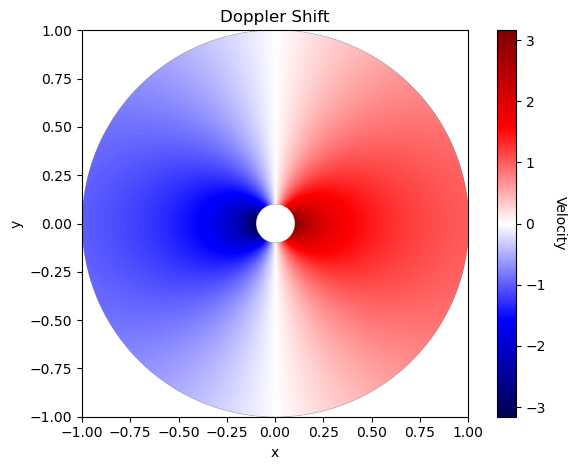

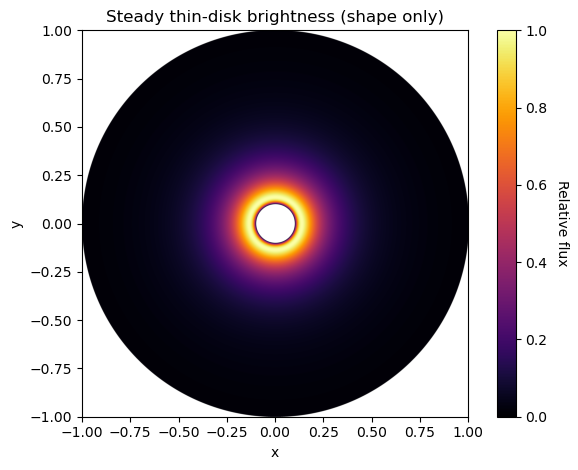

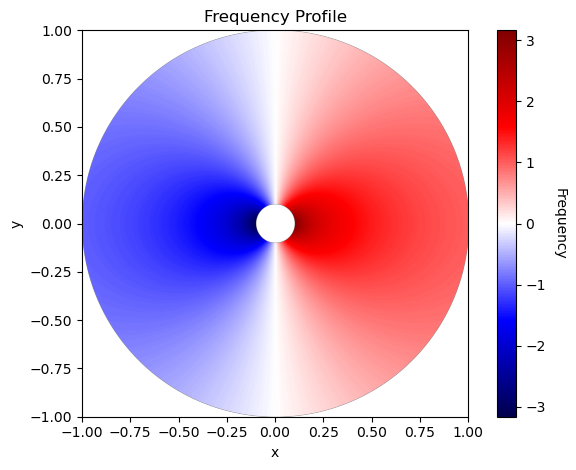

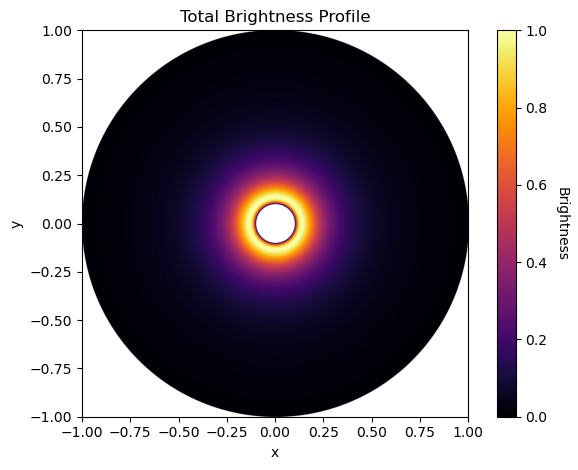

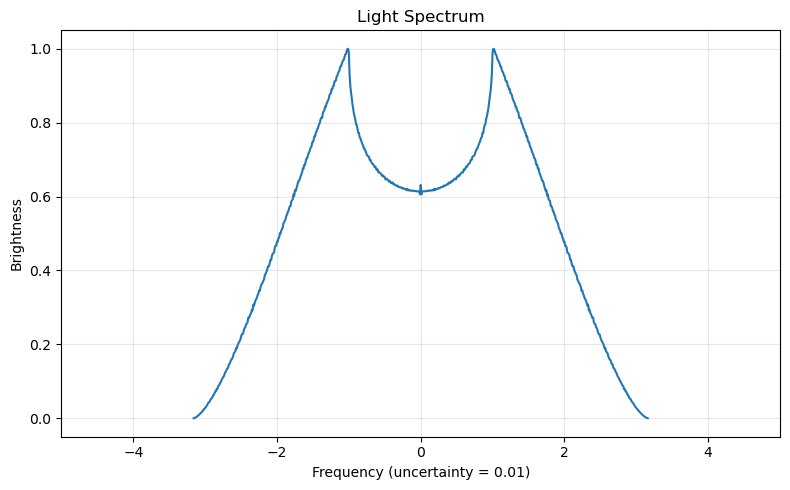

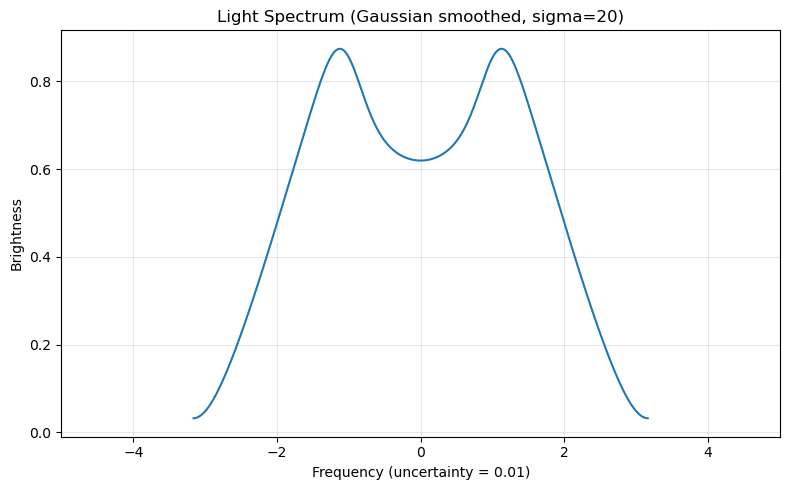

In [11]:
#Accretion Disc Model: Week 5

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from typing import Callable

# ----- constants -----

Rmax = 1            #Outer disc radius
Rmin = 0.1          #Inner disc radius
N = 5000            #Numbers of points along outer disc diameter
p = 0.01            #Bin width in frequency spectrum
Smax = 4            #Maximum Smak freqeuncy

# ----- functions -----

import numpy as np

# Return R and theta arrays and boolean mask
def make_array(Rmax: float, Rmin: float, N: int):

    dimension = np.linspace(-Rmax, Rmax, N)
    X, Y = np.meshgrid(dimension, dimension)

    R = np.hypot(X, Y)                  # radial distance
    theta = np.arctan2(Y, X)            # polar angle
    mask = (R >= Rmin) & (R <= Rmax)    # annular region

    return R, theta, mask

# Returns scalar array for parameter function
def make_profile(
    func: Callable[[np.ndarray, np.ndarray], np.ndarray],
    R: np.ndarray,
    theta: np.ndarray,
    mask: np.ndarray
) -> np.ndarray:
    profile = np.full_like(R, np.nan, dtype=float)
    profile[mask] = func(R[mask], theta[mask])
    return profile

# Plots magnitude of 2D array
def plot_profile(
    profile: np.ndarray,
    Rmax: float,
    colourmap: str = "viridis",
    title: str = "Profile",
    x_label: str = "x",
    y_label: str = "y",
    colour_bar_name: str = "Value",
    symmetric: bool = False,   # set symmetric color limits around 0
    nonneg: bool = False       # force vmin=0 and vmax=max
) -> None:

    extent = [-Rmax, Rmax, -Rmax, Rmax]

    if symmetric:
        vmax_auto = np.nanmax(np.abs(profile))
        vmin_plot = -vmax_auto
        vmax_plot =  vmax_auto
    elif nonneg:
        vmin_plot = 0.0
        vmax_plot = np.nanmax(profile)
    else:
        vmin_plot = np.nanmin(profile)
        vmax_plot = np.nanmax(profile)

    fig, ax = plt.subplots()
    img = ax.imshow(
        profile,
        extent=extent,
        origin="lower",
        cmap=colourmap,
        aspect="equal",
        vmin=vmin_plot, vmax=vmax_plot
    )
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label(colour_bar_name, rotation=270, labelpad=15)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.tight_layout()
    plt.show()

# Returns scalar array for parameter function and optionally plots it
def parameter_function(
    func: Callable[[np.ndarray, np.ndarray], np.ndarray],
    R: np.ndarray,
    theta: np.ndarray,
    mask: np.ndarray,
    Rmax: float,
    plot: bool = False,
    colourmap: str = "viridis",
    title: str = "Profile",
    x_label: str = "x",
    y_label: str = "y",
    colour_bar_name: str = "Value",
    symmetric: bool = False,   # set symmetric color limits around 0
    nonneg: bool = False       # force vmin=0 and vmax=max
) -> np.ndarray:

    profile = make_profile(func, R, theta, mask)


    if plot:
        if np.all(~np.isfinite(profile)):
            raise ValueError("Profile contains no finite values to plot.")
        else:
            plot_profile(
                profile=profile,
                Rmax=Rmax,
                colourmap=colourmap,
                title=title,
                x_label=x_label,
                y_label=y_label,
                colour_bar_name=colour_bar_name,
                symmetric=symmetric,
                nonneg=nonneg
            )

    return profile

# Returns vector rounded to resolution
def round_to_resolution(vec: np.ndarray, res: float) -> np.ndarray:
    return np.round(vec / res) * res

# Outputs two vectors
# 1st vector: bins
# 2nd vector: respective magnitudes of each bin
def sort_4_spectrum(frequency: np.ndarray,
                    brightness: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # 1) Flatten to 1-D
    f = np.asarray(frequency).ravel()
    w = np.asarray(brightness).ravel().astype(float)

    if f.shape != w.shape:
        raise ValueError(f"frequency and brightness must align elementwise; got {f.shape} vs {w.shape}")

    # 2) Drop non-finite pairs
    valid = np.isfinite(f) & np.isfinite(w)
    f = f[valid]
    w = w[valid]

    if f.size == 0:
        return np.array([]), np.array([])

    # 3) Collapse duplicates via inverse mapping
    frequency_4_plot, inverse = np.unique(f, return_inverse=True)
    brightness_4_plot = np.bincount(inverse, weights=w)

    return frequency_4_plot, brightness_4_plot

# Normalises vector to have maximum value 1
def normalise(values: np.ndarray) -> np.ndarray:
    finite = np.isfinite(values)
    if not finite.any():
        return values
    amp = np.nanmax(np.abs(values))
    if not np.isfinite(amp) or amp == 0:
        return values
    return values / amp

# Smak 1: Returns I at x for Smak Analytical solution corresponding to a
def I(a: float, x: float) -> float:
    eps = 1e-12
    y = np.nan
    if abs(x) <= 1.0:
        s = np.sqrt(1.0 - x**2)
        if a == 0.0:
            y = -((x**3)/4.0 + (3.0*x)/8.0) * s + (3.0/8.0) * np.arcsin(x)
        elif a == 0.5:
            y = (1.0/3.0) * (s**3) - s
        elif a == 1.0:
            y = -(x/2.0) * s + 0.5 * np.arcsin(x)
        elif a == 1.5:
            y = -s
        elif a == 2.0:
            y = np.arcsin(x)
        elif a == 2.5:
            y = np.log(abs((1.0 - s) / x)) if abs(x) > eps else np.nan
        else:
            raise NotImplementedError("Only a ∈ {0,0.5,1,1.5,2,2.5} supported.")
    return y

# Smak 2: Returns difference between I calculated at x_z and x_1
def I_difference(a: float, u: float, Rmin: float) -> float:
    x_z = np.clip(u, -1.0, 1.0)
    x_1 = np.clip(u*np.sqrt(Rmin), -1.0, 1.0)
    return I(a, x_z) - I(a, x_1)

# Smak 3: Returns Smak's analytical brightness value
def Calculate_Smak_Brightness(u: float, exp: float, a: float, Rmin: float) -> float:
    if abs(u) < 1e-12 and exp < 0:
        return np.nan
    difference = I_difference(a, u, Rmin)
    return (u**exp) * difference 

# Apply guassian smoothing to 1D arrary
def smooth(values: np.ndarray, sigma: float) -> np.ndarray:
    if gaussian_filter1d is None:
        raise RuntimeError("gaussian_filter1d not available; install SciPy or remove smoothing.")
    return gaussian_filter1d(values, sigma=sigma)

#Plots spectrum
def plot_spectrum(frequency_4_plot: np.ndarray,
                  brightness_4_plot_norm: np.ndarray,
                  Smak: bool = False,
                  p: float = p,
                  Smak_frequency: np.ndarray = None,
                  Smak_brightness_norm: np.ndarray = None,
                  xlim: float = 5,
                  sigma: float = None,
                  xlabel: str = "Frequency",
                  ylabel: str = "Brightness",
                  title: str = "Light Spectrum",
                  figsize: tuple[int, int] =(8, 5),
                  grid_alpha: float = 0.3
    ):

    # Make safe copies
    frequency_4_plot = np.asarray(frequency_4_plot)
    brightness_4_plot_norm = np.asarray(brightness_4_plot_normalised)
    if Smak == True:
        if Smak_frequency is None or Smak_brightness_norm is None:
            raise ValueError("Smak=True but Smak_frequency/Smak_brightness_norm not provided.")
        Smak_frequency = np.asarray(Smak_frequency)
        Smak_brightness_norm = np.asarray(Smak_brightness_norm)

    #Smoothing
    if sigma is not None and sigma > 0:
        brightness_4_plot_norm = gaussian_filter1d(brightness_4_plot_norm, sigma=sigma)
        if Smak is True:
            Smak_brightness_norm = gaussian_filter1d(Smak_brightness_norm, sigma=sigma)
        title = f"{title} (Gaussian smoothed, sigma={sigma:g})"
    elif sigma is not None and sigma < 0:
        raise ValueError("sigma must be non-negative or None.")

    
    # Plot
    plt.figure(figsize=figsize)

    if Smak:
        plt.plot(Smak_frequency, Smak_brightness_norm, linestyle='-', linewidth=2.5, label='Smak solution')
        plt.plot(frequency_4_plot, brightness_4_plot_norm, linestyle='-', label='Model spectrum')
        plt.legend()
    else:
        plt.plot(frequency_4_plot, brightness_4_plot_norm, linestyle='-')

    plt.xlabel(f"{xlabel} (uncertainty = {p})")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=grid_alpha)
    if xlim is not None:
        plt.xlim(-xlim, xlim)
    plt.tight_layout()
    plt.show()

#Adds a phase to an array of angles
def add_phase(angles: np.ndarray, phase: float) -> np.ndarray:
    return (angles + np.deg2rad(phase)) % (2 * np.pi)


#Smallest signed angular difference a-b in [-pi, pi]
def angdiff(a, b):
    return (a - b + np.pi) % (2*np.pi) - np.pi

# Steady thin-disk brightness shape function
def F_visc_shape(R, Rmin, Rmax, normalize="unit_peak"):
    """
    Steady thin-disk brightness *shape* (per face) with no M or Mdot.
    F ∝ R^{-3} * (1 - sqrt(Rmin/R)) on [Rmin, Rmax], 0 outside.
    
    normalize: "unit_peak" -> max(F)=1
               "unit_integral" -> ∫ 2π R F dR over [Rmin,Rmax] = 1
    """
    R = np.asarray(R)
    F = np.zeros_like(R, dtype=float)
    # valid ring
    m = (R >= Rmin) & (R <= Rmax)
    r = R[m]
    # steady thin-disk flux shape
    core = r**-3 * (1.0 - np.sqrt(Rmin / r))
    core = np.clip(core, 0.0, None)   # guard tiny negatives at R≈Rmin
    F[m] = core

    if not np.any(F > 0):
        return F

    if normalize == "unit_peak":
        F /= F.max()
    elif normalize == "unit_integral":
        # normalise so the *total* power per face equals 1
        # integral over area: ∫ 2π R F(R) dR
        # do it numerically using the provided R sampling
        # (assumes R is a 1D radial grid; if not, pass a 1D array here)
        # If R is 2D from meshgrid, integrate on a 1D radial grid separately.
        # Here we detect 1D vs 2D:
        if F.ndim == 1:
            # assume uniform-ish spacing (ok for your grids)
            dR = np.gradient(R)
            total = np.trapz(2*np.pi*R*F, R)
        else:
            raise ValueError("Pass a 1D radial array to normalise by integral.")
        if total > 0:
            F /= total
    else:
        raise ValueError('normalize must be "unit_peak" or "unit_integral"')

    return F

# ----- Initialise space -----

R, theta, mask = make_array(Rmax, Rmin, N)

# ----- Create profiles of paramters -----

# Doppler shifted profile
velocity = parameter_function(
    lambda r, t: np.cos(t) / np.sqrt(r),
    R, add_phase(theta, 0) , mask,
    Rmax,
    plot=1,
    colourmap="seismic",
    title="Doppler Shift",
    colour_bar_name="Velocity",
    symmetric=True
)

# Brightness profile: Steady thin-disk brightness shape - FROM CHAP 9
brightness_phys = parameter_function(
    lambda r, th: F_visc_shape(r, Rmin, Rmax, normalize="unit_peak"),
    R, theta, mask,
    Rmax,
    plot=1, colourmap="inferno",
    title="Steady thin-disk brightness (shape only)",
    colour_bar_name="Relative flux",
    nonneg=True
)


# Smak's assumed accretion disk brightness profile
a = 1 #Index magnitude of brightness function used in Smak Verification

brightnessrad = parameter_function(
    lambda r, th: r**(-a),
    R, theta, mask,
    Rmax,
    plot=0,
    colourmap="inferno",
    title=f"Radial Brightness Profile",
    colour_bar_name="Brightness",
    nonneg=True
)

# Companion Star illumination
SunAngle      = np.deg2rad(0)    # degrees, measured from +x toward +y
SunDistance   = 1.0             # multiples of (2 * Rmax); d = 2*SunDistance*Rmax
SunBrightness = 4               # overall scale factor
Sun_a         = 2.0             # falloff exponent (e.g., 2 for inverse-square)
eps           = 1e-9            # softening to avoid singularities

# Derived offset of the star from disc centre
d = 2.0 * SunDistance * Rmax

# Distance from each (r, th) on the disc to the star
brightnessstar = parameter_function(
    lambda r, th: SunBrightness * np.maximum(
        d**2 + r**2 - 2.0*d*r*np.cos(th - SunAngle), eps
    )**(-0.5 * Sun_a),
    R, theta, mask,
    Rmax,
    plot=0,
    colourmap="inferno",
    title=f"Star-Illuminated Disc: angle={SunAngle:.2f} rad, dist={SunDistance:.2f}×(2Rmax)",
    colour_bar_name="Brightness",
    nonneg=True
)

# Spot parameters
SpotR0        = 0.8 * Rmax     # center radius
SpotTheta0    = SunAngle       # center angle rad
SpotRadialHW  = 0.06 * Rmax    # radial half-width (narrow)
SpotAzArcHW   = 1.5 * Rmax    # azimuthal half-width ALONG ARC (wide -> elongated)
SpotMag       = 2            # brightness inside

# Elliptical tophat in polar arclength
# Treat SpotTheta0 as the ANCHOR at the clockwise-most end.
# Convert azimuthal half-width along arc (length) -> angle half-width (radians)
_eps = 1e-12
AzHalfAngle = SpotAzArcHW / max(SpotR0, _eps)

# Effective center is anchored-halfwidth CCW from the clockwise end:
SpotThetaCenter = SpotTheta0 + AzHalfAngle

brightnessspotstretch = parameter_function(
    lambda r, th: np.where(
        ((r - SpotR0)/SpotRadialHW)**2 +
        ((SpotR0 * angdiff(th, SpotThetaCenter))/SpotAzArcHW)**2 <= 1.0,
        SpotMag,
        0.0
    ),
    R, theta, mask,
    Rmax,
    plot=0,
    colourmap="inferno",
    title="Elongated Spot (Azimuthal Ellipse, CW tip anchored)",
    colour_bar_name="Brightness",
    nonneg=True
)

# ----- Analyse data -----

#Parameters affecting frequency
frequency = round_to_resolution(velocity, p)

#Parameters affecting brightness
brightness = brightness_phys

#Plotting net frequency and brightness profiles
plot_profile(frequency, Rmax, colourmap="seismic", title="Frequency Profile", colour_bar_name="Frequency", symmetric=True)
plot_profile(brightness, Rmax, colourmap="inferno", title="Total Brightness Profile", colour_bar_name="Brightness", nonneg=True)

frequency_4_plot, brightness_4_plot = sort_4_spectrum(frequency, brightness)

brightness_4_plot_normalised = normalise(brightness_4_plot) #Scales s.t. max value = 1

# ----- Smak -----

Smak_frequency = np.arange(-Smax, Smax + p, p)
Smak_brightness = np.full_like(Smak_frequency, np.nan, float)

exp = 2*a - 5
vec_bright = np.vectorize(lambda u: Calculate_Smak_Brightness(u, exp, a, Rmin))
Smak_brightness = vec_bright(Smak_frequency)

Smak_brightness_norm = normalise(Smak_brightness)

# ----- Plot Spectra -----

# Raw spectrum (no smoothing)
plot_spectrum(
    frequency_4_plot, brightness_4_plot_normalised,
    Smak_frequency=Smak_frequency, Smak_brightness_norm=Smak_brightness_norm,
    p=p, sigma=None, Smak=False, title="Light Spectrum"
)

# Smoothed spectrum
plot_spectrum(
    frequency_4_plot, brightness_4_plot_normalised,
    Smak_frequency=Smak_frequency, Smak_brightness_norm=Smak_brightness_norm,
    p=p, sigma=(20), Smak=False, title="Light Spectrum"
)

In [ ]:
# Brightness ring
RingInner = 0.30 * Rmax   # inner radius
RingOuter = 0.70 * Rmax   # outer radius
RingMag = 5

brightnessring = parameter_function(
    lambda r, th: np.where(
        (r >= RingInner) & (r <= RingOuter),
        RingMag,    # inside the ring
        0.0         # outside
    ),
    R, theta, mask,
    Rmax,
    plot=1,
    colourmap="inferno",
    title="Ring Brightness Profile",
    colour_bar_name="Brightness",
    nonneg=True
)

# Brightness spot
SpotR0     = 0.7 * Rmax   # radial position of the spot centre
SpotTheta0 = 2.8           # angle (radians) of the spot centre
SpotRadius = 0.15 * Rmax   # spot radius (spatial extent)
SpotMag    = 5             # brightness inside the spot

brightnessspot = parameter_function(
    lambda r, th: np.where(
        (r**2 + SpotR0**2 - 2*r*SpotR0*np.cos(th - SpotTheta0)) <= SpotRadius**2,
        SpotMag,   # inside the spot
        0.0        # outside
    ),
    R, theta, mask,
    Rmax,
    plot=1,
    colourmap="inferno",
    title="Spot Brightness Profile",
    colour_bar_name="Brightness",
    nonneg=True
)

# Brightness lin
GradTheta = 1.7   # radians; direction of INCREASE
B_min     = 0.0   # brightness at rim opposite GradTheta
B_max     = 5.0   # brightness at rim along GradTheta

brightnesslin = parameter_function(
    lambda r, th: (
        (B_min + (B_max - B_min) *
         np.clip(((r*np.cos(th))*np.cos(GradTheta) + (r*np.sin(th))*np.sin(GradTheta)) / Rmax * 0.5 + 0.5,
                 0.0, 1.0))
    ),
    R, theta, mask,
    Rmax,
    plot=1,
    colourmap="inferno",
    title="Lin Brightness Profile",
    colour_bar_name="Brightness",
    nonneg=True
)

In [ ]:
# Week 7: Getting the shape of the disc

